In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import itertools
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import csv
from datetime import datetime


# SK-learn libraries for learning.
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK libs
from nltk.tokenize import TweetTokenizer

# Load Data

In [2]:
## Load combined comments
data_path = "/Users/kwheatley/Desktop/w266_nfl/"
combined_comments = 'Combined_Comments.csv'

df = pd.read_csv(data_path+combined_comments)
df.head(2)

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,comment_created_utc_datetime,comment_created_utc_date,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc
0,drpk9pw,Corrupt-Spartan,Bengals,35,t1_drpk9pw,t1_drpk9pw,True,7lwbh9,1.514171e+09,1.514142e+09,2017-12-24 14:06:08,24-12-17,14:06:08,0,I love Lions fans cause we can drink bleach to...,7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati...,1.514137e+09
1,drpqgru,byniri_returns,Lions,27,t1_drpqgru,t1_drpqgru,True,7lwbh9,1.514178e+09,1.514149e+09,2017-12-24 16:01:57,24-12-17,16:01:57,0,"I was back and forth with this, but I'm on the...",7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati...,1.514137e+09


# Create Target Variable

In [3]:
df = df.fillna("no value")
df['bandwagon'] = df.author_flair.str.contains("Bandwagon").astype(int)
df['author_flair_nobandwagon'] = df['author_flair'].apply(lambda x: str(x).replace(' - Bandwagon',''))
df['fan_of_team_playing'] = df.apply(lambda x: x['author_flair_nobandwagon'] in x['submission_title'], axis=1)
df['fan_of_team_playing'] = df['fan_of_team_playing'].astype(int)
df['fan_of_team_playing_w_bandwagon'] = \
    np.where((df.fan_of_team_playing==1) & (df.bandwagon==1),2,
             np.where((df.fan_of_team_playing==1) & (df.bandwagon==0),1,0))
data = df

In [165]:
data = data.sort_values(by='comment_created_utc')

In [166]:
data.head()

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,...,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc,bandwagon,author_flair_nobandwagon,fan_of_team_playing,fan_of_team_playing_w_bandwagon
1675185,dl4uaev,GazzaGary,Broncos,641,t1_dl4uaev,t1_dl4uaev,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:22,0,http://i.imgur.com/aNf3ZqL,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Broncos,0,0
1676666,dl4ub3f,DFWnation,Cowboys,6,t1_dl4ub3f,t1_dl4ub3f,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:49,0,I'm ready! Let's go Cowboys!,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Cowboys,1,1
1675615,dl4ub4d,JBJesus,Patriots,29,t1_dl4ub4d,t1_dl4ub4d,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:50,0,"I cant see any of the comments on this sub, ca...",6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Patriots,0,0
1675193,dl4ubgp,LacesOutLocke,Vikings,400,t1_dl4ubgp,t1_dl4ubgp,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:03,0,Just a reminder \n\nYOU DON'T OWN ME.,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Vikings,0,0
1675766,dl4ubgy,Alvin_Kamara,Saints,73,t1_dl4ubgy,t1_dl4ubgy,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:04,0,FUCK DALLAS,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Saints,0,0


In [5]:
# Comment count
data['comment_body'].count()

2018028

# Remove Problematic Comments

In [6]:
# Remove empty comments
data = data[data.comment_body != "no value"]

In [7]:
# Remove Superbowl, Wildcard threads
data = data[
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3)') &
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3) (Second Half)') &
(data.submission_title!='Super Bowl 51 Pre Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Super Bowl 51 Post Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (10-6) at Los Angeles Rams (11-5)') &
(data.submission_title!='Game Thread: Tennessee Titans (9-7) at Kansas City Chiefs (10-6)') &
(data.submission_title!='Game Thread: Buffalo Bills (9-7) at Jacksonville Jaguars (10-6)') &
(data.submission_title!='Game Thread: Carolina Panthers (11-5) at New Orleans Saints (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (11-6) at Philadelphia Eagles (13-3)') &
(data.submission_title!='Game Thread: Tennessee Titans (10-7) at New England Patriots (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3)') &
(data.submission_title!='Game Thread: Minnesota Vikings (14-3) at Philadelphia Eagles (14-3)') 
]

In [8]:
# New comment count
data['comment_body'].count()

1563467

# Create graphs

In [9]:
# Reformat time variable
data.comment_created_utc_date = \
    data.comment_created_utc_date.map(lambda x: datetime.strptime(x,'%d-%m-%y'))

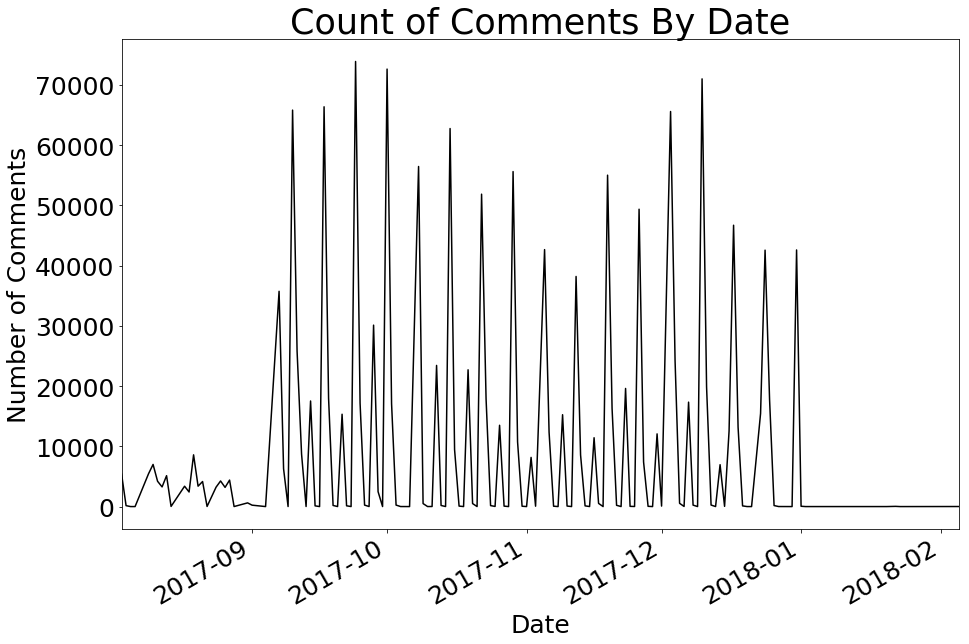

In [10]:
# This histogram is used for count of comments over time
plt.figure(figsize=(15,10))

ts = data.groupby('comment_created_utc_date')['comment_body'].count()
ax = ts.plot(cmap="gray")
plt.title('Count of Comments By Date',fontsize=35)
ax.set_ylabel('Number of Comments',fontsize=25)
ax.set_xlabel('Date',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.show()

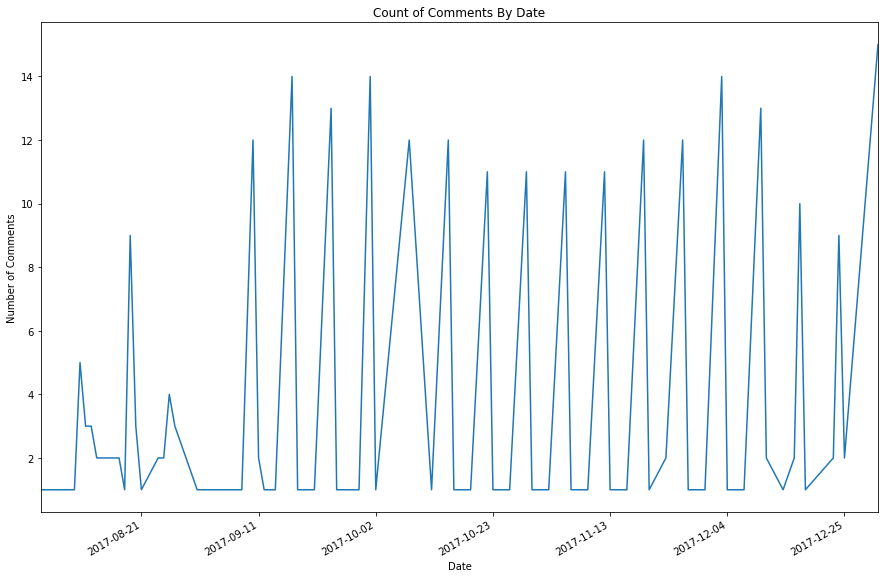

In [11]:
# This histogram gives the number of games over time
plt.figure(figsize=(15,10))

temp_data = pd.DataFrame(data.groupby(['comment_created_utc_date','submission_title'])['comment_body'].count().reset_index())

temp_data = temp_data[temp_data.comment_body>500]\
    .groupby('comment_created_utc_date')['submission_title'].nunique()

# temp_data
# temp_data[temp_data.comment_body>500].sort_values("comment_body").to_csv("temp.csv")
ax = temp_data.plot()
plt.title('Count of Comments By Date')
ax.set_ylabel('Number of Comments')
ax.set_xlabel('Date')
ax.set_xlabel('Date')
plt.show()


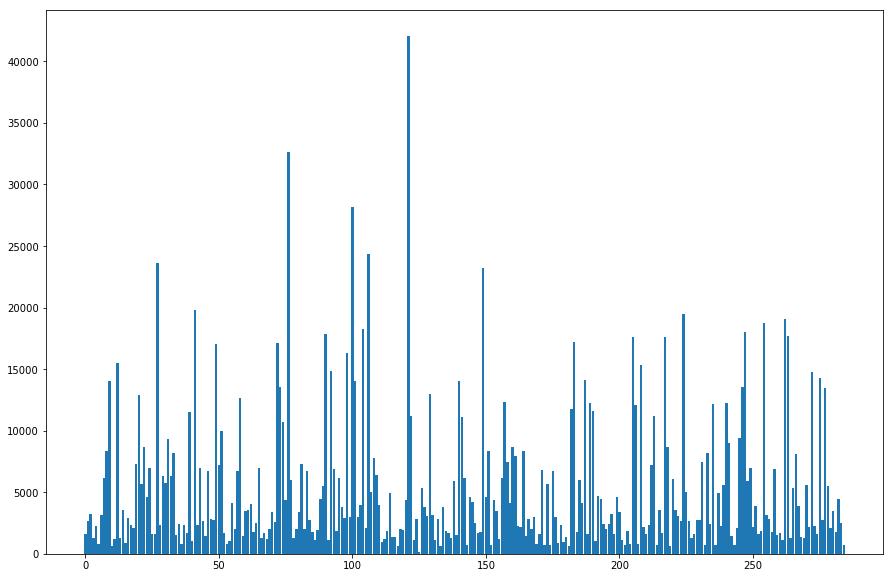

In [12]:
# This gives you the comment counts per game
plt.figure(figsize=(15,10))
labels, values = zip(*Counter(data.submission_title).items())

indexes = np.arange(len(labels))
width = .9

plt.bar(indexes, values, width)
# plt.xticks(indexes, labels,rotation='vertical')
plt.show()

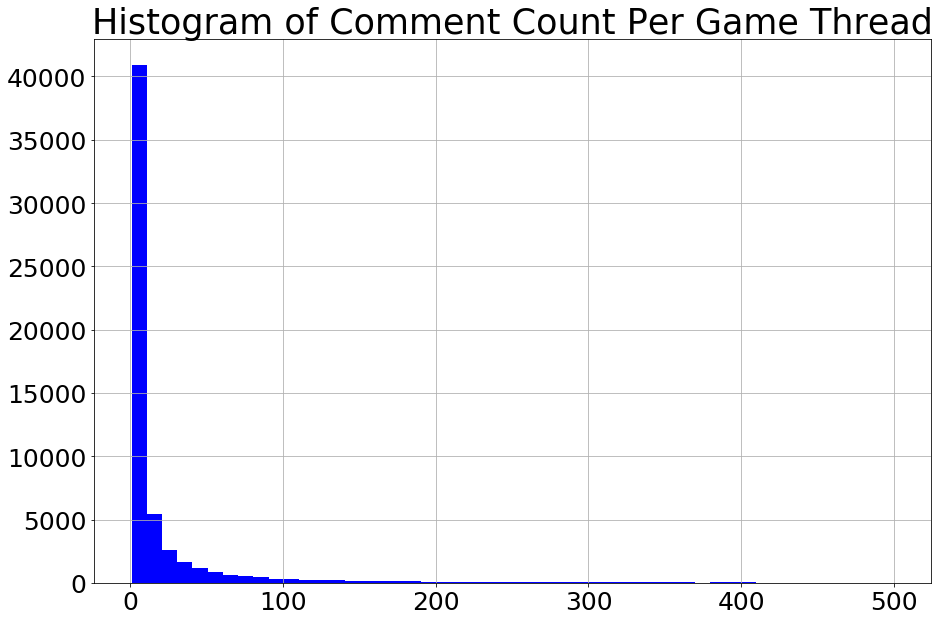

In [13]:
# This gives you the histogram of comment size per game
hist_data = pd.DataFrame(data.groupby("author")['comment_body'].count().reset_index())

plt.figure(figsize=(15,10))
ax = pd.DataFrame.hist(hist_data[hist_data.comment_body<500],
                 column='comment_body',bins=50,figsize=(15,10), ylabelsize=25, xlabelsize=25, color='blue')
plt.title('Histogram of Comment Count Per Game Thread',fontsize=35)
plt.show()

plt.figure(figsize=(15,10))
# hist_data = pd.DataFrame(data.groupby("submission_title")['comment_body'].count().reset_index())['comment_body']
# ax = plt.hist(hist_data, bins=50,facecolor='gray')  
# plt.title('Histogram of Comment Count Per Game Thread')
# # plt.xlabel('Number of Comments')
# # ax.set_xticks('Date')
# # ax.tick_params(axis='both', which='major', labelsize=18)
# plt.show()


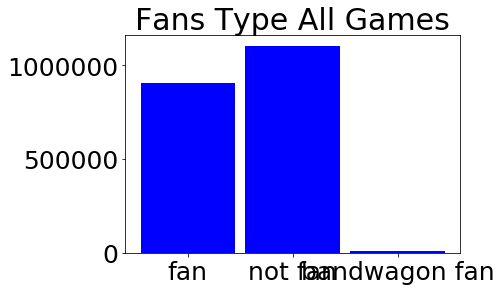

In [127]:
# Show the number of bandwagon fans. Since it is such a small percentage, 
# it's not important to look into.
labels, values = zip(*Counter(data.fan_of_team_playing_w_bandwagon).items())

indexes = np.arange(len(labels))
width = .9

labels = ["fan","not fan","bandwagon fan"]
plt.bar(indexes, values, width,color='blue')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title('Fans Type All Games',fontsize=30)
plt.xticks(indexes, labels,fontsize=25)
plt.show()

In [133]:
df.groupby('fan_of_team_playing')['comment_body'].count()
# 913873/1104155

fan_of_team_playing
0    1104155
1     913873
Name: comment_body, dtype: int64

# Data Preprocessing

In [15]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #if not word.isupper():
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [16]:
def make_data(data, target, tokenizer=TweetTokenizer(), canonize=True, stem=True):
        
    # Separate comments
    comments = data.loc[:, 'comment_body']
    labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]

    from nltk.stem import PorterStemmer
    ps = PorterStemmer()

    if stem:
        if canonize:
            comments_canon = []
            for token in x_tokens:
                stem_token = []
                for word in token:
                    stem_token.append(ps.stem(word))
                x_tokens_canon = canonicalize_words(stem_token)
                comments_canon.append(x_tokens_canon)
            x_tokens = comments_canon
        
    if not stem:
        if canonize:
            comments_canon = []
            for token in x_tokens:
                x_tokens_canon = canonicalize_words(token)
                comments_canon.append(x_tokens_canon)
            x_tokens = comments_canon
        
    return comments, x_tokens, labels

In [17]:
# Remove problematic comments

# pd.options.display.max_colwidth = 10000
data = data[data.comment_body.notnull()]
data = data[data.comment_body!='[removed]']
data = data[data.comment_body!='[deleted]']
data = data[~data.comment_body.str.contains("\^This \^message \^was \^created \^by \^a \^bot")]
data = data[~data.comment_body.str.contains("\*\*Please review the rules for")]
data = data[data.notnull()]

data['comment_body'].count()

1542039

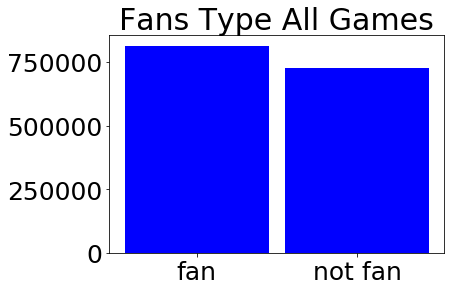

fan_of_team_playing
0    727748
1    814291
Name: comment_body, dtype: int64


In [18]:
# Show the number of bandwagon fans. Since it is such a small percentage, 
# it's not important to look into.
labels, values = zip(*Counter(data.fan_of_team_playing).items())

indexes = np.arange(len(labels))
width = .9

labels = ["fan","not fan"]
plt.bar(indexes, values, width,color='blue')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title('Fans Type All Games',fontsize=30)
plt.xticks(indexes, labels,fontsize=25)
plt.show()
print(data.groupby('fan_of_team_playing')['comment_body'].count())

In [179]:
comments, x_tokens, labels = \
make_data(data, target='fan_of_team_playing',stem=True )

In [387]:
with open('x_tokens.pickle', 'wb') as handle:
    pickle.dump(x_tokens, handle)
    
with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle)

In [20]:
# Split into test and train
train_data, test_data, train_labels, test_labels = \
    train_test_split(x_tokens, labels, test_size=0.10, random_state=42)  

In [175]:
# int(len(x_tokens) * .9)
int(len(x_tokens) * .9)

1387835

In [180]:
train_data = x_tokens[ : 1387835]
test_data = x_tokens[1387835 : ]

train_labels = labels[ : 1387835]
test_labels = labels[1387835 : ]

In [184]:
data.head()

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,...,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc,bandwagon,author_flair_nobandwagon,fan_of_team_playing,fan_of_team_playing_w_bandwagon
1675185,dl4uaev,GazzaGary,Broncos,641,t1_dl4uaev,t1_dl4uaev,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:22,0,http://i.imgur.com/aNf3ZqL,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Broncos,0,0
1676666,dl4ub3f,DFWnation,Cowboys,6,t1_dl4ub3f,t1_dl4ub3f,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:49,0,I'm ready! Let's go Cowboys!,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Cowboys,1,1
1675615,dl4ub4d,JBJesus,Patriots,29,t1_dl4ub4d,t1_dl4ub4d,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:50,0,"I cant see any of the comments on this sub, ca...",6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Patriots,0,0
1675193,dl4ubgp,LacesOutLocke,Vikings,400,t1_dl4ubgp,t1_dl4ubgp,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:03,0,Just a reminder \n\nYOU DON'T OWN ME.,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Vikings,0,0
1675766,dl4ubgy,Alvin_Kamara,Saints,73,t1_dl4ubgy,t1_dl4ubgy,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:04,0,FUCK DALLAS,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Saints,0,0


In [186]:
len(test_data)

154204

In [164]:
data.sort_values(by='comment_created_utc').head()

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,...,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc,bandwagon,author_flair_nobandwagon,fan_of_team_playing,fan_of_team_playing_w_bandwagon
1675185,dl4uaev,GazzaGary,Broncos,641,t1_dl4uaev,t1_dl4uaev,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:22,0,http://i.imgur.com/aNf3ZqL,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Broncos,0,0
1676666,dl4ub3f,DFWnation,Cowboys,6,t1_dl4ub3f,t1_dl4ub3f,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:49,0,I'm ready! Let's go Cowboys!,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Cowboys,1,1
1675615,dl4ub4d,JBJesus,Patriots,29,t1_dl4ub4d,t1_dl4ub4d,True,6rggif,1.501832e+09,1.501803e+09,...,19:30:50,0,"I cant see any of the comments on this sub, ca...",6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Patriots,0,0
1675193,dl4ubgp,LacesOutLocke,Vikings,400,t1_dl4ubgp,t1_dl4ubgp,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:03,0,Just a reminder \n\nYOU DON'T OWN ME.,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Vikings,0,0
1675766,dl4ubgy,Alvin_Kamara,Saints,73,t1_dl4ubgy,t1_dl4ubgy,True,6rggif,1.501832e+09,1.501803e+09,...,19:31:04,0,FUCK DALLAS,6rggif,Game Thread: Arizona Cardinals (0-0) at Dallas...,1.501803e+09,0,Saints,0,0


In [187]:
# Count or TF-IDF vectorize, removing stop words.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', lowercase=False, 
                             tokenizer=lambda text: text)
                             #tokenizer=lambda text: text, min_df=0.00002, max_df=0.005)

In [188]:
train_data_sparse = vectorizer.fit_transform(train_data)
test_data_sparse = vectorizer.transform(test_data)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [23]:
# Save off word counts in csv
flat_list = [item for sublist in x_tokens for item in sublist]
counts = Counter(flat_list)

with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in counts.items():
       writer.writerow([key, value])

In [189]:
counts = {}
for label in np.unique(labels):
    counts[label] = sum(labels == label)

print("Class counts:\n{}".format(counts))

Class counts:
{0: 727748, 1: 814291}


# Logistic Regression with L1 penalty

In [230]:
# load model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [231]:
lgst_l1 = SGDClassifier(loss="log", penalty="l1"
#                         ,alpha=0.000001
                       )
lgst_l1.fit(train_data_sparse, train_labels)
# save the classifier
with open('lgst_l1_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l1, fid)

In [232]:
#Create predictions and evaluate
pred_labels = lgst_l1.predict(test_data_sparse)
print("Training set score: {:.3f}".format(lgst_l1.score(train_data_sparse, train_labels)))
print("Test set score: {:.3f}".format(lgst_l1.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_l1.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

print("Number of features used: {}".format(np.sum(lgst_l1.coef_ != 0)))


Training set score: 0.559
Test set score: 0.583
Number of features used: 113
Confusion Matrix...
[[17023 46322]
 [17995 72864]]
Number of features used: 113


In [233]:
lgst_l1.intercept_

array([0.03773734])

In [234]:
n=20
prediction_probs = lgst_l1.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.07984537377143142, 1, ["we'r", 'fuck', '.'])
(0.085272186872558, 1, ["we'r", 'fuck'])
(0.09323889880477843, 1, ['at', 'least', "we'r", 'still', 'in', 'our'])
(0.09323889880477843, 1, ['now', "we'r", 'even'])
(0.09323889880477843, 1, ["we'r", 'about', 'to', 'find', 'out'])
(0.09323889880477843, 1, ["we'r", 'done'])
(0.09323889880477843, 1, ["we'r", 'still', 'in'])
(0.09601133045362054, 1, ["we'r", 'not', '.', 'you', 'are', '.'])
(0.10173765464383444, 1, ["we'r", 'play', 'stupid', '.', "we'r", 'fuck', 'if', 'we', 'keep', 'thi', 'up', '.'])
(0.10568046138349818, 1, ['he', 'had', 'it', ',', 'but', 'fuck', 'thi', '.', "we'r", 'get', '2v1ed'])
(0.1095130753640069, 1, ["we'r", 'not', '!'])
(0.1250147386494661, 1, ['i', 'have', 'no', 'idea', 'what', "we'r", 'do', 'on', 'defens', '.'])
(0.1295140120900694, 1, ['lol', "we'r", 'fuck'])
(0.1320727050224555, 1, ['god', ',', 'our', 'defens', 'is', 'fuck', 'terribl', '.', "we'r", 'just', 'not', 'a', 'good', 'team', ',', 'and', "we

In [235]:
pd.DataFrame(prob_actual).to_csv("lgst_l1_test_results.csv")

In [236]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-1.5475138980382008 mcadoo
-1.241024823259758 romo
-1.201949811115994 chief
-1.0555308212601449 nfl
-1.0474383615733123 commerci
-0.9070127961899548 gruden
-0.877735771582985 patriot
-0.8044262806863504 rex
-0.7178113232236376 footbal
-0.7103279352966481 cowboy
-0.7043137223521357 night
-0.6988762409076335 alex
-0.6607545296687893 charger
-0.655362522334286 redskin
-0.6526940128021086 raven
-0.6451028720656765 watch
-0.6380707028709114 collinsworth
-0.6246973603358086 dolphin
-0.6049084691545928 giant
-0.5482032239902034 espn
-0.5472629831173995 "
-0.5348160919895087 hunt
-0.5322871083997762 kc
-0.5095080920343942 dak
-0.49248844348478155 song
-0.47153713038179174 bengal
-0.4586036231425316 tonight
-0.41755061141822214 look
-0.407251303026249 rodger
-0.39436840525049466 wow
-0.3916191717814505 holi
-0.3836971292362085 dalton
-0.36497878145245716 bradi
-0.34020816583792923 fantasi
-0.334260944903782 saint
-0.32913280888306845 ?
-0.32737023145749944 raider
-0.30664702677920574 pat
-0.290

In [35]:
# lasso = Lasso(alpha=0.0002)
# lasso.fit(train_data, train_labels)

In [34]:
# #Create predictions and evaluate
# pred_labels = lasso.predict(test_data)
# print("Training set score: {:.2f}".format(lasso.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(lasso.score(test_data, test_labels)))
# print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

In [35]:
# n=50
# classifier=lasso

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression with L2

In [36]:
# load the model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [196]:
lgst_l2 = SGDClassifier(loss="log", penalty="l2"
#                         ,alpha=.000005
                       )
lgst_l2.fit(train_data_sparse, train_labels)
with open('lgst_l2_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l2, fid)    

In [197]:
#Create predictions and evaluate
pred_labels = lgst_l2.predict(test_data_sparse)
print("Training set score: {:.3f}".format(lgst_l2.score(train_data_sparse, train_labels)))
print("Test set score: {:.3f}".format(lgst_l2.score(test_data_sparse, test_labels)))
#print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

print("Number of features used: {}".format(np.sum(lgst_l2.coef_ != 0)))


Training set score: 0.589
Test set score: 0.590
Confusion Matrix...
[[24168 39177]
 [24011 66848]]
Number of features used: 91407


In [198]:
lgst_l2.intercept_

array([0.06372053])

In [199]:
n=20
prediction_probs = lgst_l2.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.11022592618273708, 1, ["we'r", 'fuck', '.'])
(0.1180570003307031, 1, ["we'r", 'fuck'])
(0.1369579437651347, 1, ["we'r", 'not', '.', 'you', 'are', '.'])
(0.13824756040703323, 1, ["we'r", 'play', 'stupid', '.', "we'r", 'fuck', 'if', 'we', 'keep', 'thi', 'up', '.'])
(0.14022110045579728, 1, ['at', 'least', "we'r", 'still', 'in', 'our'])
(0.14022110045579728, 1, ['now', "we'r", 'even'])
(0.14022110045579728, 1, ["we'r", 'about', 'to', 'find', 'out'])
(0.14022110045579728, 1, ["we'r", 'done'])
(0.14022110045579728, 1, ["we'r", 'still', 'in'])
(0.14077371857564513, 1, ['he', 'had', 'it', ',', 'but', 'fuck', 'thi', '.', "we'r", 'get', '2v1ed'])
(0.15144890004302036, 1, ["we'r", 'not', '!'])
(0.15511933399933597, 1, ['god', "we'r", 'so', 'fuck', 'bad', '.'])
(0.15756072320940162, 1, ['where', "we'r", 'go', 'we', "don't", 'need', 'offens'])
(0.15789273319108643, 1, ['god', ',', 'our', 'defens', 'is', 'fuck', 'terribl', '.', "we'r", 'just', 'not', 'a', 'good', 'team', ',', 'a

In [200]:
pd.DataFrame(prob_actual).to_csv("lgst_l2_test_results.csv")

In [201]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-1.1412277619780145 chief
-1.0971770715787441 mcadoo
-1.061795949899104 romo
-0.9403952906261954 commerci
-0.9397715777379263 nfl
-0.9167692684754031 patriot
-0.9025060176112413 gruden
-0.8559694298889747 rex
-0.8190126855586144 cowboy
-0.8151321443403662 redskin
-0.8111656271427616 kc
-0.8095371588160275 fantasi
-0.8026167665661843 collinsworth
-0.7973169064718977 charger
-0.7865293243469721 dolphin
-0.7849211287425808 raven
-0.7518260110563236 alex
-0.7468383540347527 hunt
-0.7452816850651689 giant
-0.7291426307918327 espn
-0.7282828182740473 footbal
-0.7153692136812478 cutler
-0.7103086677174879 song
-0.7083219464320561 bengal
-0.7041081775679666 toni
-0.6931825112598806 dak
-0.6917779118161129 dalton
-0.6786524079776829 night
-0.6665175231025828 tune
-0.6409485370752857 bronco
-0.639005784002209 root
-0.6293758184641528 watch
-0.6268549560813863 tonight
-0.6253181024481265 al
-0.6203527387575284 cousin
-0.6182029825483011 flacco
-0.6039283751201686 raider
-0.5990027167890374 saint


In [43]:
# rdg = Ridge(alpha=5)
# rdg.fit(train_data, train_labels)

In [44]:
# #Create predictions and evaluate
# pred_labels = rdg.predict(test_data)
# print("Training set score: {:.2f}".format(rdg.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(rdg.score(test_data, test_labels)))
# #print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

In [45]:
# n=50
# classifier=rdg

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# ElasticNet Regression

In [223]:
lgst_elnet = SGDClassifier(loss="log", penalty="elasticnet"
#                            ,alpha=.000005
                           ,alpha=.001                           
                          )
lgst_elnet.fit(train_data_sparse, train_labels)
with open('lgst_elnet_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_elnet, fid)    

In [229]:
#Create predictions and evaluate
pred_labels = lgst_elnet.predict(test_data_sparse)
print("Training set score: {:.3f}".format(lgst_elnet.score(train_data_sparse, train_labels)))
print("Test set score: {:.3f}".format(lgst_elnet.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_elnet.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Training set score: 0.534
Test set score: 0.584
Number of features used: 68
Confusion Matrix...
[[ 6572 56773]
 [ 7402 83457]]


In [225]:
lgst_elnet.intercept_

array([0.04720323])

In [226]:
n=20
prediction_probs = lgst_elnet.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.3106388270991639, 1, ["we'r", 'fuck', '.'])
(0.31081114270056376, 1, ['thi', 'defens', '.', 'what', 'the', 'fuck', '.'])
(0.31734170740796364, 1, ['after', 'he', 'fuck', 'him', 'up', '.'])
(0.31734170740796364, 1, ['and', 'we', 'fuck', 'that', 'up', '.'])
(0.31734170740796364, 1, ['eeehhhhhh', 'fuck', 'that', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])
(0.31734170740796364, 1, ['fuck', '.'])

Least likely fans
(0.5719796770394767, 0, ['who', 'the', 'hell

In [227]:
pd.DataFrame(prob_actual).to_csv("lgst_elnet_test_results.csv")

In [228]:
n=20
classifier=lgst_elnet

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (round(coef,2), feat)

print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

-0.34 "
-0.24 romo
-0.23 ?
-0.22 commerci
-0.2 nfl
-0.2 watch
-0.19 chief
-0.18 footbal
-0.15 mcadoo
-0.14 look
-0.11 like
-0.1 wow
-0.09 game
-0.09 cowboy
-0.08 lol
-0.08 holi
-0.07 giant
-0.06 night
-0.06 gruden
-0.05 lmao

0.59 fuck
0.44 defens
0.43 .
0.41 we'r
0.24 !
0.21 offens
0.2 run
0.18 hold
0.13 play
0.1 DG
0.1 stop
0.1 today
0.1 3rd
0.1 drive
0.09 pleas
0.08 yeah
0.08 ref
0.08 tackl
0.07 half
0.07 d


In [208]:
test_labels.shape

(154204,)

In [209]:
print("Accuracy...")
print(lgst_elnet.score(test_data_sparse, test_labels))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy...
0.5837267515758346
Confusion Matrix...
[[ 6459 56886]
 [ 7305 83554]]


In [54]:
# elnet = ElasticNet(alpha=0.0001, l1_ratio=0.25)
# elnet.fit(train_data, train_labels)

In [55]:
# n=50
# classifier=elnet

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression

In [217]:
# Train model
lgreg = LogisticRegression()
lgreg.fit(train_data_sparse, train_labels)
with open('lgreg_classifier.pkl', 'wb') as fid:
    pickle.dump(lgreg, fid)    

In [218]:
train_labels.sum()
# 1387844
# 732907
732907/1387844

0.5280903329192618

In [219]:
lgreg.intercept_

array([0.1984512])

In [220]:
#Create predictions and evaluate
pred_labels = lgreg.predict(test_data_sparse)
acc = metrics.accuracy_score(test_labels, pred_labels)
print("Accuracy on test set: {:.02%}".format(acc))
print('Test Data:')

feature_names = vectorizer.get_feature_names()
# class_labels = lgreg.classes_
# print(class_labels)
# print(classification_report(test_labels, pred_labels, target_names = class_labels, digits=1))
#print(classification_report(test_labels, pred_labels, target_names = ['fan_lose_close', 'fan_lose_notclose', 'fan_win_close', 'fan_win_notclose'], digits=3))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)
print("Number of features used: {}".format(np.sum(lgreg.coef_ != 0)))


Accuracy on test set: 59.00%
Test Data:
Confusion Matrix...
[[29243 34102]
 [29117 61742]]
Number of features used: 91407


In [222]:
n=15
classifier=lgreg

feature_names = vectorizer.get_feature_names()

topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (round(coef,2), feat)

print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

-3.17 #eagl
-2.95 DG.DGDGDGDG
-2.82 juejueju
-2.78 mcdonough
-2.49 tune
-2.47 england'
-2.44 aedeo
-2.43 rex
-2.41 skycam
-2.41 tony'
-2.34 wembley
-2.32 skatterbug
-2.32 jumanji
-2.29 yahoo
-2.27 sergio

3.11 cyru
2.95 burton
2.75 dola
2.73 robiski
2.63 we'r
2.61 hollist
2.51 haley
2.45 doug'
2.44 spielman
2.42 stew
2.42 ifedi
2.41 teco
2.4 debo
2.36 sendejo
2.32 warmack


In [215]:
n=20
prediction_probs = lgreg.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.04552396917335255, 1, ['fuck', 'you', 'robiski'])
(0.049761837670493914, 1, ['dola', 'with', 'the', 'first'])
(0.05209782249931272, 1, ["we'r", 'fuck', '.'])
(0.05455844392481268, 1, ["we'r", 'fuck'])
(0.05605788677363266, 1, ['at', 'least', "we'r", 'still', 'in', 'our'])
(0.05605788677363266, 1, ['now', "we'r", 'even'])
(0.05605788677363266, 1, ["we'r", 'about', 'to', 'find', 'out'])
(0.05605788677363266, 1, ["we'r", 'done'])
(0.05605788677363266, 1, ["we'r", 'still', 'in'])
(0.05755077531580899, 1, ['fuck', 'ifedi', '.'])
(0.05965313810667516, 1, ['with', 'the', 'amount', 'of', 'injuri', "we'v", 'had', ',', "we'r", 'lucki', 'to', 'have', 'had', 'DG', 'win', '.'])
(0.06048751540478359, 1, ["i'm", 'glad', "we'r", 'see', 'more', 'yeldon', 'than', 'ivori', 'final', '.'])
(0.06063320314125431, 1, ["i'll", 'take', 'it', '.', "we'r", 'move', 'the', 'ball', 'to', 'not', 'lose', 'field', 'posit', 'and', "we'v", 'got', 'point', '.'])
(0.060646671682968, 1, ['fuck', 'off', '

In [216]:
pd.DataFrame(prob_actual).to_csv("lgst_test_results.csv")

# Exploration

In [459]:
comments = data
comments['comment_body'] = comments.comment_body.map(lambda x: x.lower())
chaz_comments = comments[comments.comment_body.str.contains('ournette')]

In [460]:
pd.DataFrame(\
comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='submission_title',\
                                                                 ascending=False)\
.to_csv("temp.csv")

In [461]:
pd.DataFrame(\
chaz_comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='comment_body',\
                                                                 ascending=False)


,submission_title,fan_of_team_playing,comment_body
5,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,81
33,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),1,73
43,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),1,43
32,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),0,37
57,Game Thread: Los Angeles Rams (3-2) at Jacksonville Jaguars (3-2),1,33
42,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),0,33
41,Game Thread: Jacksonville Jaguars (2-1) at New York Jets (1-2),1,28
54,Game Thread: Los Angeles Chargers (3-5) at Jacksonville Jaguars (5-3),0,26
56,Game Thread: Los Angeles Rams (3-2) at Jacksonville Jaguars (3-2),0,25
6,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),1,24


In [254]:
chaz_comments

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon,fan_binary
70831,70831,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley: *barely runs the ball at all in the first half*\n\nhaley: *calls 4 rush plays in a row*\n\nthis man can find no balance in his life.,1,0,1,1
70976,70976,Patriots,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"""in 2006, haley filed a 1.5 million-dollar lawsuit against mcdonald's after his wife found a dead rat in her salad.""\n\nfrom todd haley's wikipedia. honestly, i'm not surprised.",0,0,0,0
71230,71230,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems to have forgotten that play action is an option,1,0,1,1
72969,72969,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley called decent plays last week so expect us to throw 50% screens and 3rd and 1 deep balls all game,1,0,1,1
73595,73595,Seahawks,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems like a fun guy lol,0,0,0,0
73605,73605,Vikings,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley probably slams 3 whiskeys at halftime every week to maintain his image.,0,0,0,0
73999,73999,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"who's ready for haley to take this momentum and call run, run, pass?",1,0,1,1
74890,74890,no value,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),only todd haley could ruin an offense this stacked with talent,0,0,0,0
75066,75066,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley loves the delayed handoff on first and 10 for a loss of yardage!!!!!!!!!!!!,1,0,1,1
76761,76761,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),not jinxing it but we haven't seen a todd haley bomb(tm) yet,1,0,1,1


In [465]:
pd.DataFrame(chaz_comments.groupby(['submission_title','fan_of_team_playing'])\
             ['comment_body'].count().reset_index())

,submission_title,fan_of_team_playing,comment_body
0,Game Thread: Atlanta Falcons (0-1) at Pittsburgh Steelers (1-0),1,4
1,Game Thread: Atlanta Falcons (3-2) at New England Patriots (4-2),0,1
2,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),0,1
3,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),1,1
4,Game Thread: Atlanta Falcons (9-5) at New Orleans Saints (10-4),1,1
5,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,1
6,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),0,5
7,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),1,44
8,Game Thread: Buffalo Bills (8-6) at New England Patriots (11-3),0,3
9,Game Thread: Chicago Bears (1-1) at Tennessee Titans (1-1),1,1


In [115]:
percent_chart = pd.read_csv("percent_chart.csv")
percent_chart = percent_chart.sort_values(by='sort_index')
percent_chart = percent_chart.reset_index()

In [116]:
percent_chart.head()

,index,submission_title,not_fan,fan,total_comments,percent_not_fan,percent_not_fans,date,sort_index
0,0,Game Thread: Arizona Cardinals (0-0) at Dallas Cowboys (0-0),4129,1336,5465.0,0.755535,50-75%,8/3/17,1.0
1,1,Game Thread: Houston Texans (0-0) at Carolina Panthers (0-0),3400,2043,5443.0,0.624656,50-75%,8/9/17,2.0
2,2,Game Thread: Denver Broncos (0-0) at Chicago Bears (0-0),1266,1609,2875.0,0.440348,25-50%,8/10/17,3.0
3,3,Game Thread: Jacksonville Jaguars (0-0) at New England Patriots (0-0),143,925,1068.0,0.133895,0-25%,8/10/17,4.0
4,4,Game Thread: Minnesota Vikings (0-0) at Buffalo Bills (0-0),272,794,1066.0,0.255159,0-25%,8/10/17,5.0


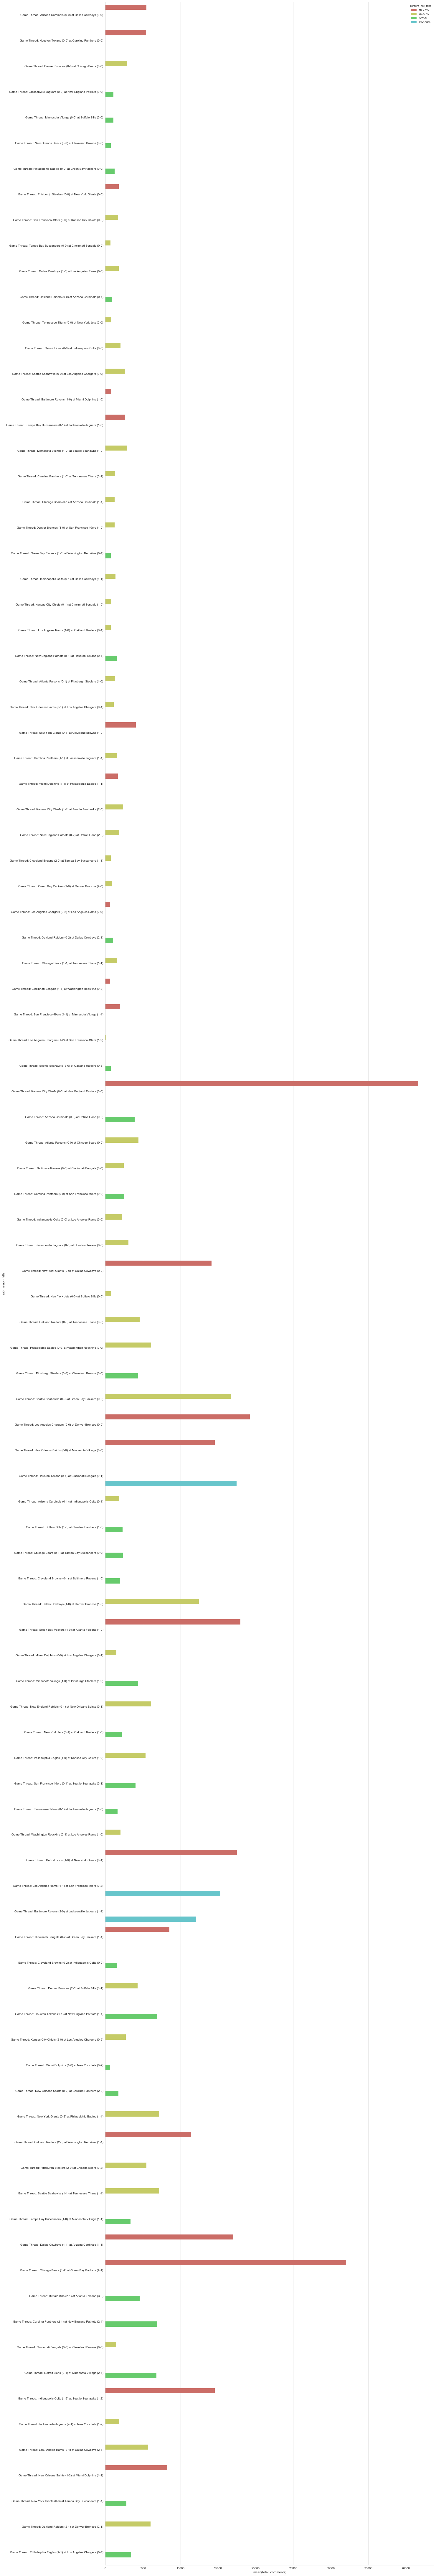

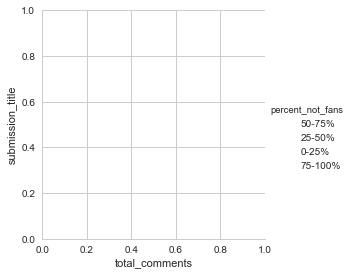

In [209]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(20, 160)

ax = sns.factorplot(orient='h', ax=ax, y='submission_title', x='total_comments', \
                   hue='percent_not_fans', kind='bar', data=percent_chart.head(100) )
sns.set_style("whitegrid") 
sns.set_palette("hls")
# ax.add_legend(label_order = ['0-25%',''0','-1','-2''])
plt.show()